<a href="https://colab.research.google.com/github/carbon77/colab/blob/master/VKR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import sklearn as sk
from IPython.display import clear_output

## Data Preprocessing

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/vkr_dataset"
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512

image_classes = ['benign', 'malignant', 'normal']
image_names = np.array([], dtype=str)
image_mask_names = np.array([], dtype=str)
image_labels = np.array([])

for image_class in image_classes:
  for image_name in os.listdir(os.path.join(DATASET_PATH, image_class)):
    if image_name.endswith(".png") and  "_mask" not in image_name:
      image_names = np.append(image_names, os.path.join(DATASET_PATH, image_class, image_name))
      image_mask_names = np.append(image_mask_names, os.path.join(DATASET_PATH, image_class, image_name.replace(".png", "_mask.png")))
      image_labels = np.append(image_labels, image_classes.index(image_class))

image_names.shape, image_mask_names.shape, image_labels.shape

((780,), (780,), (780,))

(array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], dtype=float32),
 array([0.5602564 , 0.26923078, 0.17051283], dtype=float32))

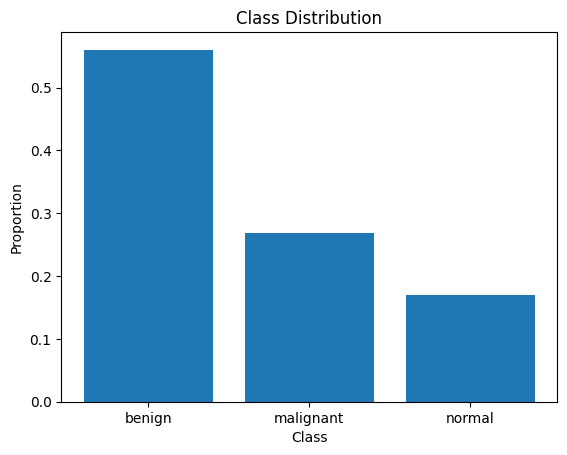

In [ ]:
def find_class_distribution(image_labels):
  class_distribution = np.sum(image_labels, axis=0)
  total_samples = len(image_labels)
  class_distribution = class_distribution / total_samples
  return class_distribution

# Plot the class distribution
image_labels = keras.utils.to_categorical(image_labels, num_classes=3)
class_distribution = find_class_distribution(image_labels)
plt.bar(image_classes, class_distribution)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Proportion")
image_labels[:5], class_distribution

In [ ]:
from sklearn.model_selection import train_test_split

# Stratified split
images_train, images_test, image_masks_train, image_masks_test, image_labels_train, image_labels_test = train_test_split(
    image_names, image_mask_names, image_labels,  test_size=0.2, stratify=image_labels)

In [ ]:
images_train.shape, images_test.shape

((624,), (156,))

In [ ]:
train_distribution = find_class_distribution(image_labels_train)
test_distribution = find_class_distribution(image_labels_test)
train_distribution, test_distribution

(array([0.5608974 , 0.26923078, 0.16987179], dtype=float32),
 array([0.5576923 , 0.26923078, 0.17307693], dtype=float32))

In [ ]:
def normalize_image(image, mask):
  image = tf.cast(image, tf.float32) / 255.0
  mask = tf.cast(mask, tf.float32) / 255.0

  return image, mask

def load_image(datapoint):
  try:
    image = tf.io.read_file(datapoint['image'])
  except:
    return None
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
  image.set_shape([None, None, 3])

  mask = tf.io.read_file(datapoint['mask'])
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.image.resize(mask, (IMAGE_WIDTH, IMAGE_HEIGHT), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  mask.set_shape([None, None, 1])

  image, mask = normalize_image(image, mask)
  return image, (mask, datapoint['label'])

In [ ]:
TRAIN_LENGTH = len(images_train)
BATCH_SIZE = 16
BUFFER_SIZE = 32
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices({'image': images_train, 'mask': image_masks_train, 'label': image_labels_train})
dataset_test = tf.data.Dataset.from_tensor_slices({'image': images_test, 'mask': image_masks_test, 'label': image_labels_test})

dataset_train = dataset_train.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_test = dataset_test.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_train

<_ParallelMapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None)))>

In [ ]:
class Augment(keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.augment_image = keras.layers.RandomFlip(mode="horizontal", seed=42)
    self.augment_mask = keras.layers.RandomFlip(mode="horizontal", seed=42)

  def call(self, input, output):
    image = self.augment_image(input)
    mask = self.augment_mask(output[0])
    return image, (mask, output[1])

In [ ]:
train_batches = (
    dataset_train
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
test_batches = dataset_test.batch(BATCH_SIZE)

In [ ]:
def get_class(label):
  classes = ["Benign", "Malignant", "Normal"]
  return classes[np.argmax(label)]

def display(display_list, labels):
  plt.figure(figsize=(15, 15))
  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))

    if i == 1:
      plt.text(15, 25, f'True class: {labels[0]}', color="white", bbox=dict(facecolor='green', alpha=0.5))

    if i == 2:
      plt.text(15, 25, f'Predicted class: {labels[1]}', color="white", bbox=dict(facecolor='green', alpha=0.5))
  plt.show()

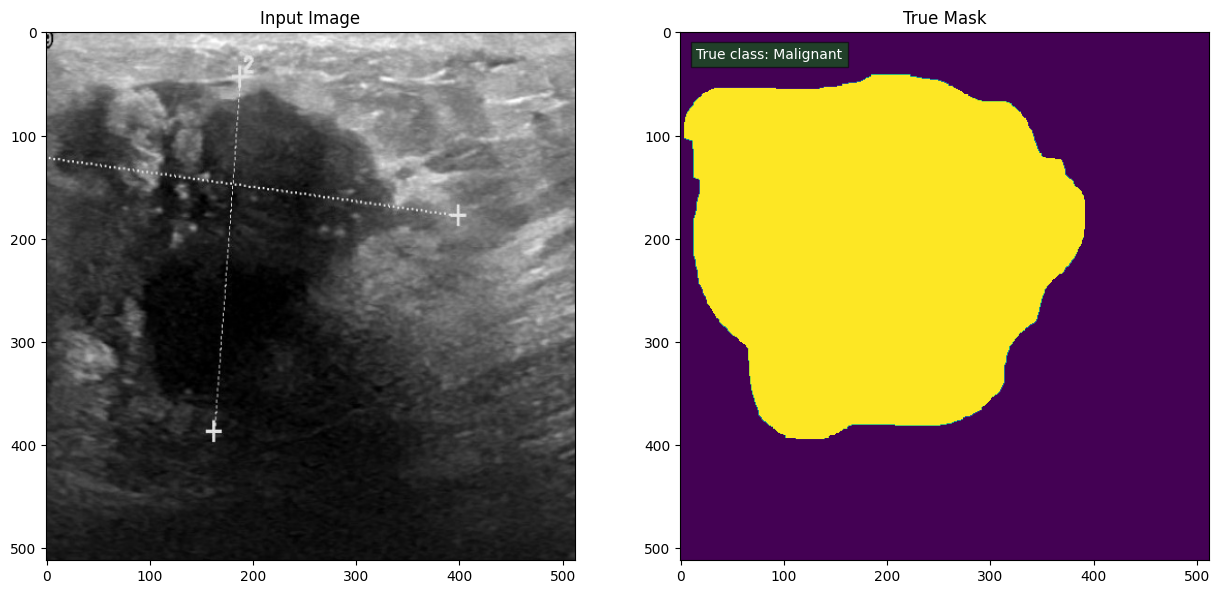

In [ ]:
for images, outputs in train_batches.take(1):
  sample_image, sample_mask, sample_label = images[0], outputs[0][0], outputs[1][0]
  display([sample_image, sample_mask], [get_class(sample_label)])

# Model Creation

In [ ]:
base_model = keras.applications.vgg16.VGG16(
    include_top=False,
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
    weights="imagenet",
)

layer_names = [
    'block1_pool',
    'block2_pool',
    'block3_pool',
    'block4_pool',
    'block5_pool',
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False
down_stack.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [ ]:
def decoder_block(inputs, skip_features, num_filters):
  upsample = keras.Sequential([
      keras.layers.Conv2DTranspose(
          num_filters, kernel_size=3, strides=2, padding="same", use_bias=False
      ),
      keras.layers.BatchNormalization(),
      keras.layers.ReLU()
  ])
  x = upsample(inputs)
  x = keras.layers.Concatenate()([x, skip_features])
  return x

In [ ]:
def unet_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), output_segmentation_channels=2, output_classification_channels=3):
  inputs = keras.layers.Input(shape=input_shape)
  skips = down_stack(inputs)
  s1, s2, s3, s4, s5 = skips

  d1 = decoder_block(s5, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  unet_outputs = keras.layers.Conv2DTranspose(
      output_segmentation_channels, kernel_size=3, strides=2, padding="same", name="unet"
  )(d4)

  classifier = keras.Sequential(name="classifier", layers=[
      keras.layers.Flatten(),
      keras.layers.Dense(512, activation="relu"),
      keras.layers.Dense(output_classification_channels, activation="softmax")
  ])
  classifier_outputs = classifier(s5)

  model = keras.Model(inputs, [unet_outputs, classifier_outputs])
  return model

In [ ]:
model = unet_model(output_segmentation_channels=2, output_classification_channels=3)
model.compile(
    optimizer="adam",
    loss={
        'unet': keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        'classifier': keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    metrics=["accuracy"],
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 256, 256, 64),       1471468   ['input_3[0][0]']             
                              (None, 128, 128, 128),      8                                       
                              (None, 64, 64, 256),                                                
                              (None, 32, 32, 512),                                                
                              (None, 16, 16, 512)]                                                
                                                                                            

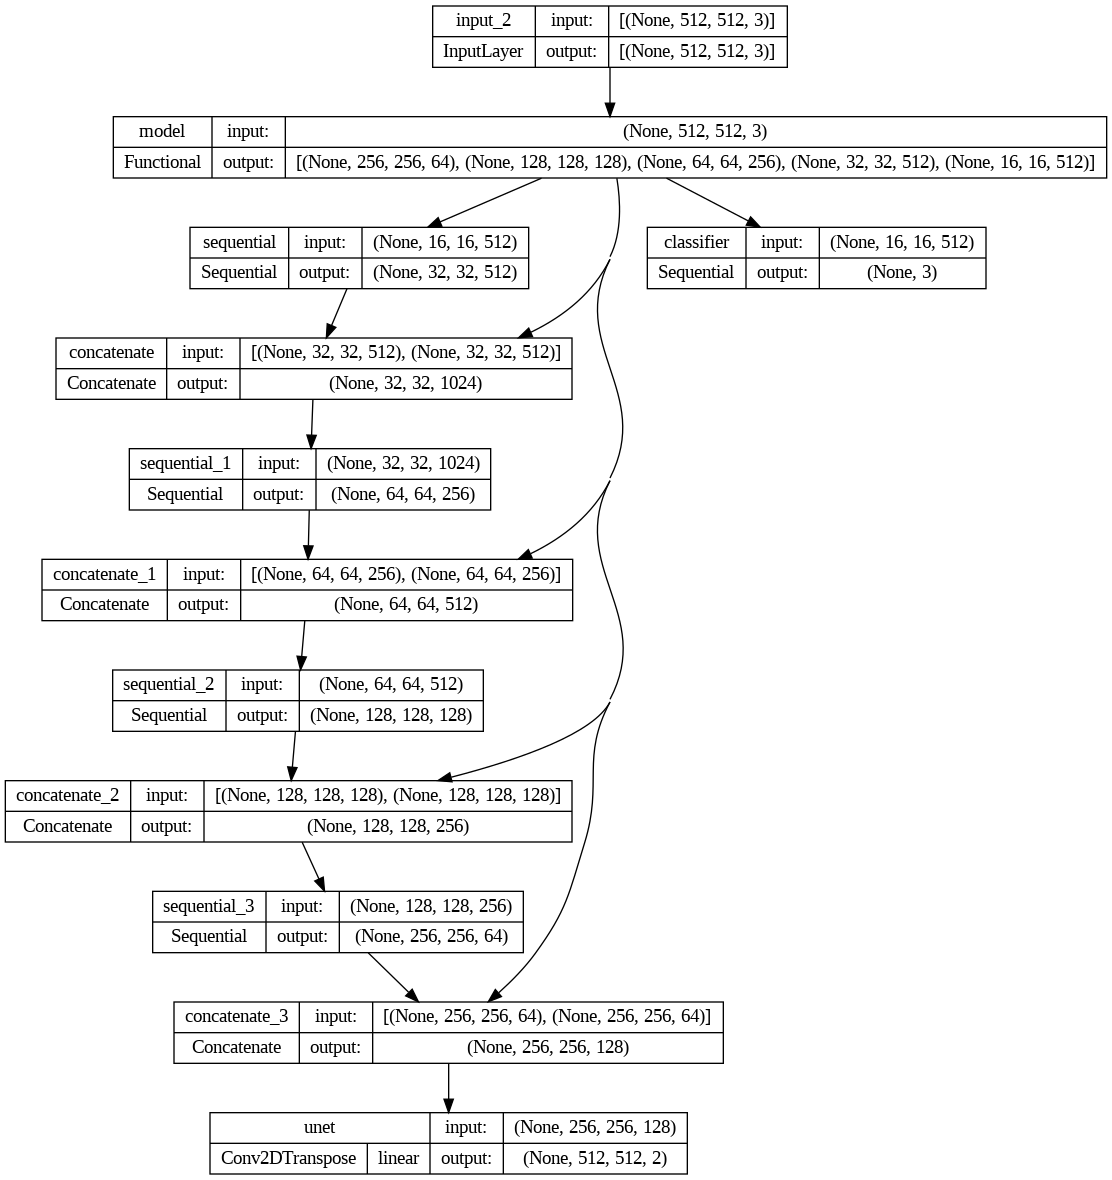

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    expand_nested=False,
    show_layer_activations=True
    )

1/1 [==============================] - 0s 70ms/step


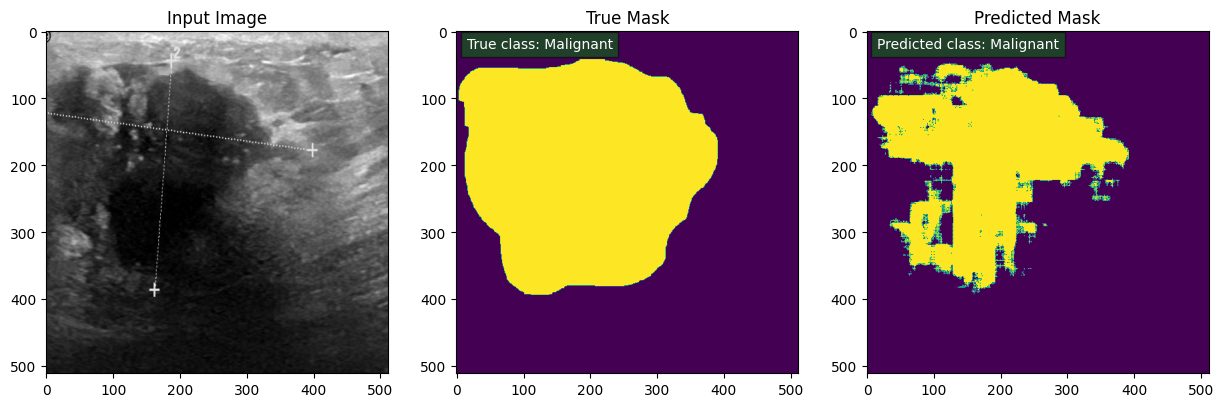

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


def show_predictions(dataset=None, num=1):
  if dataset:
    for image, (mask, label) in dataset.take(num):
      pred_mask, pred_labels = model.predict(image[tf.newaxis, ...])
      display([image, mask, create_mask(pred_mask)], [get_class(label), get_class(pred_labels.flatten())])
  else:
    pred_mask, pred_labels = model.predict(sample_image[tf.newaxis, ...])
    display([sample_image, sample_mask, create_mask(pred_mask)], [get_class(sample_label), get_class(pred_labels.flatten())])


show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


1/1 [==============================] - 0s 31ms/step


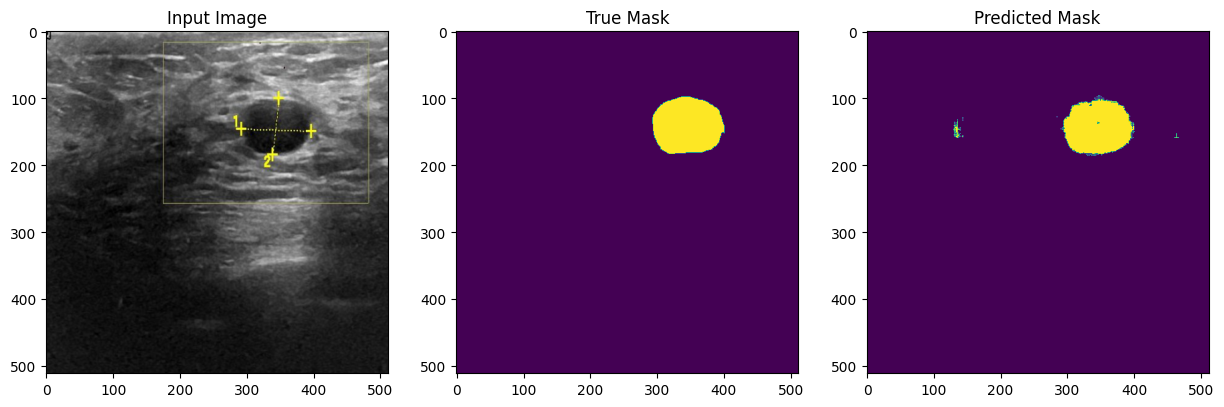


Sample Prediction after epoch 40

39/39 [==============================] - 30s 773ms/step - loss: 0.2335 - unet_loss: 0.1409 - classifier_loss: 0.0926 - unet_accuracy: 0.9474 - classifier_accuracy: 0.9679 - val_loss: 1.6867 - val_unet_loss: 0.1874 - val_classifier_loss: 1.4993 - val_unet_accuracy: 0.9381 - val_classifier_accuracy: 0.7500


In [ ]:
EPOCHS = 40
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(dataset_test) // BATCH_SIZE // VAL_SUBSPLITS

history = model.fit(
  train_batches,
  epochs=EPOCHS,
  steps_per_epoch=STEPS_PER_EPOCH,
  validation_data=test_batches,
  validation_steps=VALIDATION_STEPS,
  callbacks=[DisplayCallback()],
)

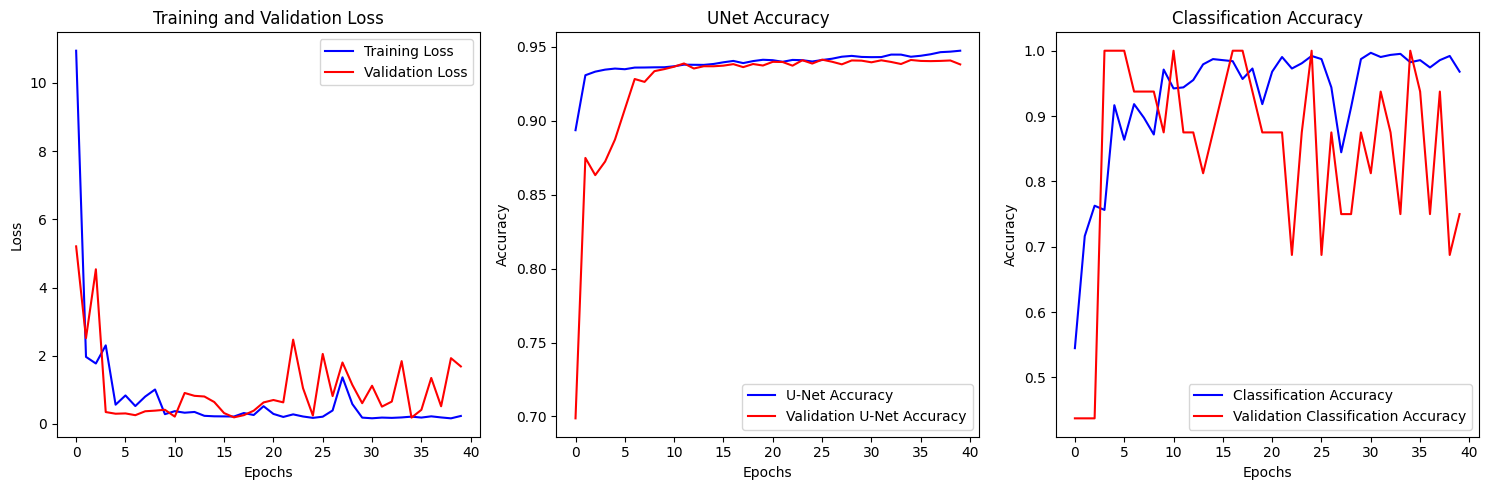

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
unet_accuracy = history.history['unet_accuracy']
classifier_accuracy = history.history['classifier_accuracy']

epochs = range(1,len(history.history['loss'])+1)

plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.plot(history.epoch, history.history['loss'], 'b', label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(history.epoch, history.history['unet_accuracy'], 'b', label='U-Net Accuracy')
plt.plot(history.epoch, history.history['val_unet_accuracy'], 'r', label='Validation U-Net Accuracy')
plt.title('UNet Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,3,3)
plt.plot(history.epoch, history.history['classifier_accuracy'], 'b', label='Classification Accuracy')
plt.plot(history.epoch, history.history['val_classifier_accuracy'], 'r', label='Validation Classification Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def compute_metrics(pred_mask, true_mask):
  class_wise_iou = []
  class_wise_dice_score = []
  smooth = 0.00001

  for i in range(3):
    intersection = np.sum((pred_mask == i) * (true_mask == i))
    true_area = np.sum(true_mask == i)
    pred_area = np.sum(pred_mask == i)
    combined_area = true_area + pred_area

    iou = (intersection + smooth) / (combined_area - intersection + smooth)
    class_wise_iou.append(iou)

    dice_score = 2 * ((intersection + smooth) / (true_area + pred_area + smooth))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

1/1 [==============================] - 0s 66ms/step


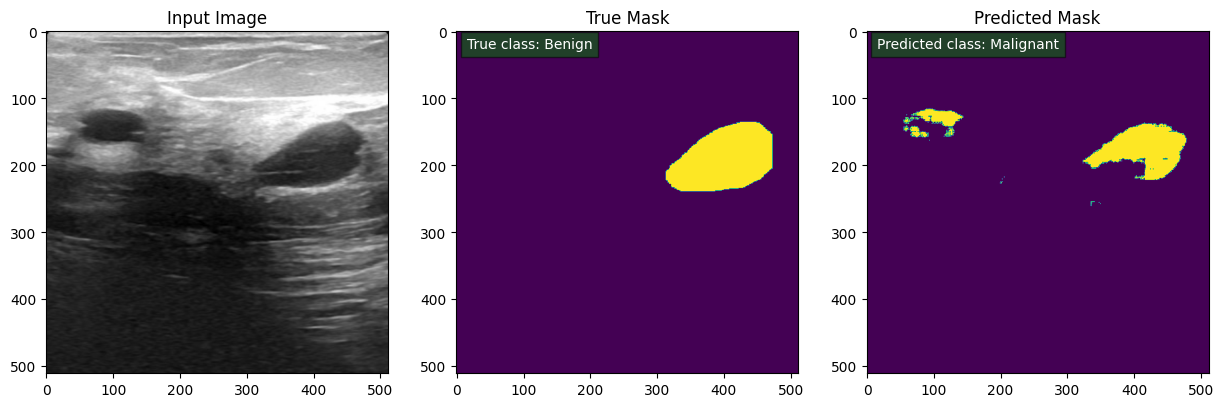

1/1 [==============================] - 0s 62ms/step


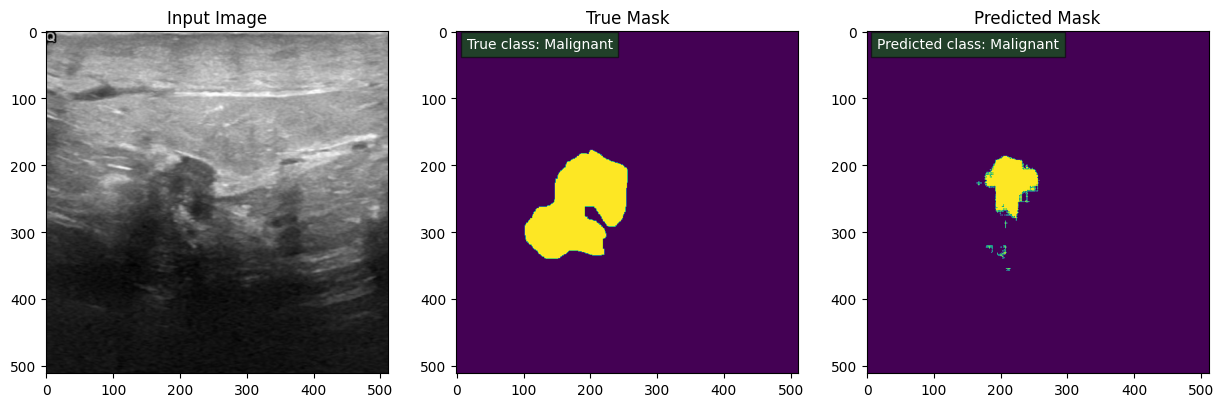

In [ ]:
show_predictions(dataset_test, 2)